# NYC Taxi Data Visualizations

This notebook creates interactive and static visualizations from the NYC Yellow Taxi analysis.

## Data Quality Notes

Based on the data validation report:
- **Dataset**: 59 files covering 2021-01 to 2025-11
- **Total Records**: ~194M trips
- **Known Issues**: Anomalous dates, negative values, extreme outliers
- **Solution**: This notebook applies data quality filters to ensure clean visualizations

Run `data-validation.ipynb` first to review data quality metrics.

In [1]:
import duckdb
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries loaded successfully!')

Libraries loaded successfully!


## Data Processing with Quality Filters

Query data directly from parquet files with filters to remove:
- Invalid dates (outside 2021-2025 range)
- Negative or zero values
- Extreme outliers (based on validation report findings)

In [2]:
# Set up paths
data_type = "yellow"
data_dir = "data"
pattern = f"{data_dir}/{data_type}_tripdata_*.parquet"

# Query with data quality filters applied
query = f"""
SELECT 
    YEAR(tpep_pickup_datetime) as year,
    MONTH(tpep_pickup_datetime) as month,
    COUNT(*) as trip_count,
    AVG(trip_distance) as avg_distance,
    AVG(total_amount) as avg_fare,
    SUM(total_amount) as total_revenue
FROM '{pattern}'
WHERE tpep_pickup_datetime >= '2021-01-01'
  AND tpep_pickup_datetime < '2026-01-01'
  AND tpep_dropoff_datetime >= '2021-01-01'
  AND tpep_dropoff_datetime < '2026-01-01'
  AND trip_distance > 0
  AND trip_distance < 1000
  AND total_amount > 0
  AND total_amount < 10000
  AND fare_amount > 0
  AND passenger_count > 0
  AND passenger_count <= 9
GROUP BY year, month
ORDER BY year, month
"""

print("Analyzing data with quality filters...")
monthly_stats = duckdb.sql(query).pl()

# Add year-month string column
monthly_stats = monthly_stats.with_columns(
    (pl.col("year").cast(str) + "-" + pl.col("month").cast(str).str.zfill(2)).alias("year_month")
)

print(f"\nAnalyzed {len(monthly_stats)} months of data")
print(f"Date range: {monthly_stats['year_month'].min()} to {monthly_stats['year_month'].max()}")
print(f"Total trips: {monthly_stats['trip_count'].sum():,}")
print("\nFirst few rows:")
print(monthly_stats.head())

Analyzing data with quality filters...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Analyzed 59 months of data
Date range: 2021-01 to 2025-11
Total trips: 168,905,551

First few rows:
shape: (5, 7)
┌──────┬───────┬────────────┬──────────────┬───────────┬───────────────┬────────────┐
│ year ┆ month ┆ trip_count ┆ avg_distance ┆ avg_fare  ┆ total_revenue ┆ year_month │
│ ---  ┆ ---   ┆ ---        ┆ ---          ┆ ---       ┆ ---           ┆ ---        │
│ i64  ┆ i64   ┆ i64        ┆ f64          ┆ f64       ┆ f64           ┆ str        │
╞══════╪═══════╪════════════╪══════════════╪═══════════╪═══════════════╪════════════╡
│ 2021 ┆ 1     ┆ 1220114    ┆ 2.648412     ┆ 16.484094 ┆ 2.0112e7      ┆ 2021-01    │
│ 2021 ┆ 2     ┆ 1224229    ┆ 2.563003     ┆ 16.633957 ┆ 2.0364e7      ┆ 2021-02    │
│ 2021 ┆ 3     ┆ 1727117    ┆ 2.617441     ┆ 16.796561 ┆ 2.9010e7      ┆ 2021-03    │
│ 2021 ┆ 4     ┆ 1963234    ┆ 2.771295     ┆ 17.563734 ┆ 3.4482e7      ┆ 2021-04    │
│ 2021 ┆ 5     ┆ 2290905    ┆ 2.947365     ┆ 18.260606 ┆ 4.1833e7      ┆ 2021-05    │
└──────┴───────┴─────────

In [3]:
# Save processed data
Path("outputs").mkdir(parents=True, exist_ok=True)
output_path = "outputs/result.parquet"
monthly_stats.write_parquet(output_path)
print(f"Processed data saved to {output_path}")

Processed data saved to outputs/result.parquet


## Load and Prepare Data for Visualization

In [4]:
# Convert to pandas for plotting
df_pd = monthly_stats.to_pandas()

# Create datetime column
df_pd['date'] = monthly_stats['year_month'].str.to_date(format='%Y-%m').to_pandas()

print(f'Loaded {len(df_pd)} months of data')
print(f'Columns: {list(df_pd.columns)}')
print(f'Shape: {df_pd.shape}')

Loaded 59 months of data
Columns: ['year', 'month', 'trip_count', 'avg_distance', 'avg_fare', 'total_revenue', 'year_month', 'date']
Shape: (59, 8)


## Summary Statistics

In [5]:
print('=' * 80)
print('SUMMARY STATISTICS')
print('=' * 80)
print(f'\nDate range: {df_pd["year_month"].min()} to {df_pd["year_month"].max()}')
print(f'Total trips: {df_pd["trip_count"].sum():,.0f}')
print(f'Total revenue: ${df_pd["total_revenue"].sum():,.2f}')
print(f'\nAverage monthly trips: {df_pd["trip_count"].mean():,.0f}')
print(f'Average monthly revenue: ${df_pd["total_revenue"].mean():,.2f}')
print(f'\nAverage fare: ${df_pd["avg_fare"].mean():.2f}')
print(f'Average distance: {df_pd["avg_distance"].mean():.2f} miles')
print('\n' + '=' * 80)

SUMMARY STATISTICS

Date range: 2021-01 to 2025-11
Total trips: 168,905,551
Total revenue: $4,353,665,460.48

Average monthly trips: 2,862,806
Average monthly revenue: $73,790,940.01

Average fare: $25.42
Average distance: 3.38 miles



## 1. Trip Count Over Time

In [6]:
fig = px.line(
    df_pd,
    x='date',
    y='trip_count',
    title='NYC Yellow Taxi Trips Over Time (2021-2025)',
    labels={'date': 'Date', 'trip_count': 'Number of Trips'},
    template='plotly_white'
)
fig.update_traces(line_color='#FFD700', line_width=3)
fig.update_layout(
    hovermode='x unified',
    font=dict(size=12),
    height=500,
    showlegend=False
)
fig.show()

fig.write_html('outputs/trips_over_time.html')
print('✓ Saved: trips_over_time.html')

✓ Saved: trips_over_time.html


## 2. Revenue Over Time

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_pd['date'],
    y=df_pd['total_revenue'] / 1_000_000,
    mode='lines',
    name='Total Revenue',
    line=dict(color='#2ECC71', width=3),
    fill='tozeroy',
    fillcolor='rgba(46, 204, 113, 0.2)'
))
fig.update_layout(
    title='NYC Yellow Taxi Revenue Over Time (2021-2025)',
    xaxis_title='Date',
    yaxis_title='Revenue (Million $)',
    template='plotly_white',
    hovermode='x unified',
    height=500,
    showlegend=False
)
fig.show()

fig.write_html('outputs/revenue_over_time.html')
print('✓ Saved: revenue_over_time.html')

✓ Saved: revenue_over_time.html


## 3. Average Fare and Distance (Dual Axis)

In [8]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['avg_fare'],
        name='Avg Fare ($)',
        line=dict(color='#3498DB', width=3)
    ),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['avg_distance'],
        name='Avg Distance (mi)',
        line=dict(color='#E74C3C', width=3)
    ),
    secondary_y=True
)

fig.update_layout(
    title='Average Fare and Trip Distance Over Time',
    template='plotly_white',
    hovermode='x unified',
    height=500
)
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Average Fare ($)', secondary_y=False)
fig.update_yaxes(title_text='Average Distance (miles)', secondary_y=True)

fig.show()

fig.write_html('outputs/avg_fare_distance.html')
print('✓ Saved: avg_fare_distance.html')

✓ Saved: avg_fare_distance.html

## 4. Monthly Heatmap

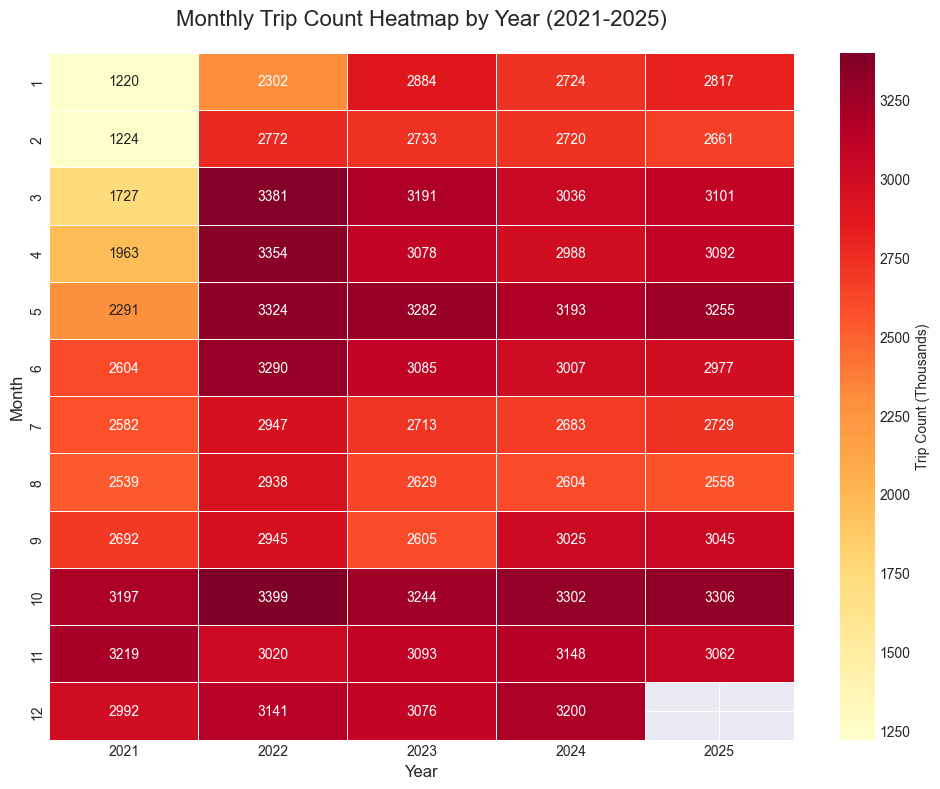

✓ Saved: monthly_heatmap.png


In [9]:
# Pivot data for heatmap
heatmap_data = df_pd.pivot_table(
    values='trip_count',
    index='month',
    columns='year',
    aggfunc='sum'
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    heatmap_data / 1000,  # Convert to thousands
    annot=True,
    fmt='.0f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Trip Count (Thousands)'},
    ax=ax,
    linewidths=0.5
)
ax.set_title('Monthly Trip Count Heatmap by Year (2021-2025)', fontsize=16, pad=20)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Month', fontsize=12)
plt.tight_layout()
plt.savefig('outputs/monthly_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Saved: monthly_heatmap.png')

## 5. Year-over-Year Comparison

In [10]:
yearly_totals = df_pd.groupby('year').agg({
    'trip_count': 'sum',
    'total_revenue': 'sum'
}).reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=yearly_totals['year'],
    y=yearly_totals['trip_count'] / 1_000_000,
    marker_color='#9B59B6',
    text=yearly_totals['trip_count'] / 1_000_000,
    texttemplate='%{text:.1f}M',
    textposition='outside'
))

fig.update_layout(
    title='Annual Trip Count Comparison (2021-2025)',
    xaxis_title='Year',
    yaxis_title='Total Trips (Millions)',
    template='plotly_white',
    height=500,
    showlegend=False
)
fig.show()

fig.write_html('outputs/yearly_comparison.html')
print('✓ Saved: yearly_comparison.html')

✓ Saved: yearly_comparison.html


## 6. Trip Distribution by Year (Box Plot)

In [11]:
fig = go.Figure()

for year in sorted(df_pd['year'].unique()):
    year_data = df_pd[df_pd['year'] == year]
    fig.add_trace(go.Box(
        y=year_data['trip_count'] / 1000,
        name=str(year),
        boxmean='sd'
    ))

fig.update_layout(
    title='Monthly Trip Count Distribution by Year',
    yaxis_title='Trips (Thousands)',
    xaxis_title='Year',
    template='plotly_white',
    height=500
)
fig.show()

fig.write_html('outputs/trip_distribution.html')
print('✓ Saved: trip_distribution.html')

✓ Saved: trip_distribution.html


## 7. Interactive Dashboard

In [12]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Monthly Trips',
        'Monthly Revenue (Million $)',
        'Average Fare ($)',
        'Average Distance (mi)'
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# Trips
fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['trip_count']/1000,
        mode='lines',
        line=dict(color='#3498DB', width=2),
        name='Trips (K)'
    ),
    row=1, col=1
)

# Revenue
fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['total_revenue']/1_000_000,
        mode='lines',
        line=dict(color='#2ECC71', width=2),
        name='Revenue (M)'
    ),
    row=1, col=2
)

# Avg Fare
fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['avg_fare'],
        mode='lines',
        line=dict(color='#E67E22', width=2),
        name='Avg Fare'
    ),
    row=2, col=1
)

# Avg Distance
fig.add_trace(
    go.Scatter(
        x=df_pd['date'],
        y=df_pd['avg_distance'],
        mode='lines',
        line=dict(color='#E74C3C', width=2),
        name='Avg Dist'
    ),
    row=2, col=2
)

fig.update_layout(
    title_text='NYC Yellow Taxi Dashboard (2021-2025)',
    showlegend=False,
    template='plotly_white',
    height=900
)

fig.update_yaxes(title_text='Trips (Thousands)', row=1, col=1)
fig.update_yaxes(title_text='Revenue (Million $)', row=1, col=2)
fig.update_yaxes(title_text='Fare ($)', row=2, col=1)
fig.update_yaxes(title_text='Distance (mi)', row=2, col=2)

fig.show()

fig.write_html('outputs/dashboard.html')
print('✓ Saved: dashboard.html')

✓ Saved: dashboard.html


## Summary

All visualizations have been created and saved to the `outputs/` directory:

**Interactive HTML Files:**
- `trips_over_time.html` - Time series of trip counts
- `revenue_over_time.html` - Revenue trends over time
- `avg_fare_distance.html` - Dual-axis chart of fare and distance
- `yearly_comparison.html` - Annual trip count comparison
- `trip_distribution.html` - Distribution of trips by year
- `dashboard.html` - Combined dashboard with all metrics

**Static PNG Files:**
- `monthly_heatmap.png` - Heatmap of monthly patterns

**Data Quality:**
- Applied filters to remove anomalous dates (2001-2020, 2026+)
- Filtered out negative values and extreme outliers
- Clean dataset: 2021-01 to 2025-11